In [1]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [384]:
def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x
    pairs['temp'] = timeline(period)
    
    X = pairs[['x', 'temp']]
    X = sm.add_constant(X)
    model = sm.OLS(pairs['y'], X).fit()
    return model

#O desvio padrão de uma estimativa é chamado de erro padrão
def stderr(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.bse['temp'],
            "angular":model.bse['x'],
            "intercept":model.bse['const']}
    
def residue(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    temp = timeline(period)
    res = y-coef['angular']*x-temp*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def lot(y_lot, coef):
    return [y_lot, int(y_lot*coef['angular'])]

def returns(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def correlation(y, x, period):
    y_log, x_log = returns(y, x, period)
    return y_log.corr(x_log)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def invert(y, x, period):
    coef_main = coefficients(y, x, period)
    coef_invert = coefficients(x, y, period)
    if (abs(coef_main['temp'])<=abs(coef_invert['temp'])):
        return False
    return True

def ratio_diff(y, x, period):
    coef = coefficients(y, x, period)
    res = residue(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    return y-x
    
def intercept_coef(y, x, period):
    res = residue(y, x, period)
    diff = ratio_diff(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = ratio_diff(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def ornstein_uhlenbeck(y, x, period):
    coef = intercept_coef(y, x, period)
    
    beta = -np.log(1+intercept_coef(y, x, period))
    alpha = -(coef/intercept_inter(y, x, period))
    
    std = residue(y, x, period).std()
    sigma=std*np.sqrt(np.log(1+coef)/(np.power((1+coef),2)-1))
    
    half = 2/beta
    return {
        "halffile": half,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma
    }

def halflife_ser(y, x, period):
    return ornstein_uhlenbeck(y, x, period)['halffile']

def halflile(series):
    lag = np.roll(series, 1)
    lag[0] = 0
    ret = series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)
    res = sm.OLS(ret, lag2).fit()
    half_life = int(round(-np.log(2) / res.params[1],0))

    if half_life <= 0:
        half_life = 1
    return half_life
    
def statisticspair(y, x, desv_input, period):
    res = residue(y, x, period)
    std = res.std()
    return {
        "std": std,
        "std_up": desv_input*std,
        "std_down": -desv_input*std,
        "mean": res.mean(),
        "min": np.min(res)-2*std,
        "max": np.max(res)+2*std
    }

def trade_stop(y, x, period):
    res = residue(y, x, period)
    
    # acima do quadro "ESTATÍSTICAS"
    std_down = res.mean()-3.1*res.std()
    std_up = res.mean()+3.1*res.std()
    
    est = coefficients(y, x, period)
    l_res = res[0]
    price = x[0]
    
    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def trade_output(y, x, period):
    price = x[0]
    est = coefficients(y, x, period)
    value1 = (est['angular']*price+est['intercept']+est['temp']*period)/price
    value2 = 1/((est['angular']*price+est['intercept']+est['temp']*period)/price)
    return max(value1, value2)

def trade_input(y, x, period):
    price = x[0]
    res = residue(y, x, period)
    l_res = res[0]
    est = coefficients(y, x, period)
    std_up = 2*res.std()
    std_down = -2*res.std()

    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def ratio_current(y, x):
    ratio = y[0]/x[0]
    return {
        "ratio": ratio,
        "value": 1/ratio
    }

def loss_percent(y, x, period):
    return -abs(trade_stop(y, x, period)/trade_input(y, x, period)-1)

def current_percent(y, x, period):
    ratio = ratio_current(y, x)
    return abs(trade_output(y, x, period)/max(ratio['ratio'], ratio['value'])-1)

def return_percent(y, x, period):
    return abs(trade_output(y, x, period)/trade_input(y, x, period)-1)

def loss(y, x, lot, period):
    return y[0]*lot*loss_percent(y, x, period)

def gain(y, x, lot, period):
    return current_percent(y, x, period)*lot*y[0]
    
def sinal(value):
    if(value < 0):
        return -1
    return 1

def dickey_fuller(series):
    model = ts.adfuller(series, 1)
    p_value = model[1]
    statistic = model[0]

    # Dickey-Fuller
    is_stationary = False
    if (p_value < .05):
        is_stationary = True

    # Augmented Dickey Fuller (ADF)
    perc_stat = 0
    if (abs(statistic) > abs(model[4]['1%'])):
        perc_stat = 99
    elif (abs(statistic) > abs(model[4]['5%'])):
        perc_stat = 95
    elif (abs(statistic) > abs(model[4]['10%'])):
        perc_stat = 90
        
    return {
        "is_stationary": is_stationary,
        "p_value": p_value,
        "adf": perc_stat,
        "statistic": statistic
    }

#função DESVQ do excel
def desvq(values):
    return np.power(values-values.mean(), 2).sum()

#função EPADYX do excel
def epadyx(y, x):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    X = sm.add_constant(res)
    fit = sm.OLS(rdiff, X).fit()
    return np.sqrt(fit.mse_resid)
    
def adf_ser(y, x, period):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    res[0]=0
    rdiff[0]=0

    inter_cof = intercept_coef(y, x, period)
    return inter_cof/(epadyx(rdiff, res)/np.sqrt(desvq(res)))

def rejeitado_h0(adf):
    if adf<=0:
        if adf<=-4.32: return 99
        if adf<=-3.67: return 95
        if adf<=-3.28: return 90
    else:
        if adf<=-3.58: return 99
        if adf<=-3.22: return 95
        if adf<=-2.6: return 90
    return 0

def dickey_fuller_ger(y, x, period):
    adf_statistic = adf_ser(y, x, period)
    rej = rejeitado_h0(adf_statistic)
    return {
        "statistic": adf_statistic,
        "adf": rej
    }

def signal(y, x, desv_input, period):
    y, x, get_values(y, x, period)
    resid = residue(y, x, period)[::-1]
    
    std = resid.std()
    resid_current = resid.iloc[-1]
    zscore_up = desv_input*std
    zscore_down = -desv_input*std
    zcurrent = 0
    descr = ''
    
    # >0; resíduo acima da linha 0
    if(resid_current > resid.mean()):
        descr = 'Short/Long'
        zcurrent = zscore_up
    else:
        descr = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resid_current)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return {
        "descr": descr, 
        "resid_current": resid_current, 
        "percent_dist_mean": percent}

def check_periods(y, x):
    rows=[]
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        if (dickey_fuller(residue(y, x, period))['is_stationary']):
            rows.append(period)
    return rows

def find(data):
    rows = []
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
                
            for period in [250, 240, 220, 200, 180, 160, 140, 120, 100]:
                y, x = get_values(data[y_symbol], data[x_symbol], period)
                dickey = dickey_fuller(residue(y, x, period))
                
                # find only an is stationary, then break looping
                if (dickey['is_stationary']):
                    coeff = coefficients(y, x, period)
                    rows.append([period, y_symbol, x_symbol, dickey['p_value'], dickey['adf'], coeff['angular']])
                    break
    return rows

def find_pairs(data):
    df_pairs = pd.DataFrame(find(data), columns=['Period', 'Dependent', 'Independent', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        half = halflile(residue(y, x, period))
        pairs['HalfLife'].iloc[i]=half

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)

        corr = correlation(y, x, period)
        pairs['Corr'].iloc[i] = corr
        
def apply_signal(data, pairs, desv_input):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        sig = signal(y, x, desv_input, period)
        pairs['Signal'].iloc[i] = sig['descr']
        pairs['SignalStr'].iloc[i] = sig['percent_dist_mean']
        
def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        periods_ok = check_periods(data[row['Dependent']],  data[row['Independent']])

        descr = ''
        for per in periods_ok:
            if (descr!=''): descr=descr+','
            descr=descr+str(per)

        pairs['PeriodQt'].iloc[i] = len(periods_ok)
        pairs['PeriodStr'].iloc[i] = descr
        
def plot_residue2(y, x, period, desv_input=2, padronizar=True):
    plot_residue(residue(y, x, period), desv_input=desv_input, padronizar=padronizar)
    
def plot_residue(resid, desv_input=2, padronizar=True):
    resid = resid[::-1]
    if (padronizar):
        resid = zscore(resid)
    std = resid.std()
    resid.plot(figsize=(15, 6), linewidth=2)

    plt.xlabel('')
    plt.axhline(resid.mean())
    plt.axhline(0, color='black',label='mean') # Add the mean of residual
    plt.axhline(desv_input*std, color='red', linestyle='--', linewidth=2)
    plt.axhline(-desv_input*std, color='green', linestyle='--', linewidth=2)

In [132]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]

In [134]:
pairs = find_pairs(data)

In [135]:
apply_halflife(data, pairs)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12


In [136]:
apply_corr(data, pairs)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12,0.343890


In [137]:
apply_signal(data, pairs, 2)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567,Long/Short,0.417122
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147,Long/Short,0.097942
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416,Short/Long,0.406829
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329,Long/Short,0.825008
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12,0.343890,Long/Short,1.03255


In [138]:
apply_periods(data, pairs)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr,PeriodQt,PeriodStr
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567,Long/Short,0.417122,6,"160,180,200,220,240,250"
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147,Long/Short,0.097942,1,100
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416,Short/Long,0.406829,5,"100,200,220,240,250"
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329,Long/Short,0.825008,6,"100,120,140,160,200,240"
1898,250,VIVT4,WEGE3,0.041362,95,0.446910,12,0.343890,Long/Short,1.03255,9,"100,120,140,160,180,200,220,240,250"


In [139]:
pairs

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr,PeriodQt,PeriodStr
0,250,ABEV3,AZUL4,0.018109,95,0.117062,9,0.615910,Short/Long,1.12466,4,"100,220,240,250"
1,100,ABEV3,B3SA3,0.000230,99,0.235832,2,0.628383,Long/Short,0.275412,1,100
2,240,ABEV3,BBAS3,0.046590,95,0.220007,9,0.552417,Short/Long,0.889388,6,"100,160,180,200,220,240"
3,250,ABEV3,BBDC3,0.049430,90,0.342484,11,0.579072,Short/Long,0.894757,8,"100,120,140,160,180,200,220,250"
4,250,ABEV3,BBDC4,0.030424,95,0.349573,11,0.564318,Short/Long,0.781056,9,"100,120,140,160,180,200,220,240,250"
...,...,...,...,...,...,...,...,...,...,...,...,...
1894,250,USIM5,WEGE3,0.017265,95,0.283155,11,0.459567,Long/Short,0.417122,6,"160,180,200,220,240,250"
1895,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147,Long/Short,0.097942,1,100
1896,250,VALE3,VVAR3,0.038695,95,1.138446,10,0.533416,Short/Long,0.406829,5,"100,200,220,240,250"
1897,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329,Long/Short,0.825008,6,"100,120,140,160,200,240"


In [264]:
#ABEV3 AZUL4
y_symbol = 'ABEV3'
x_symbol = 'BBDC4'
period = 200

In [265]:
y, x = get_values(data[y_symbol], data[x_symbol], period)

In [266]:
print('{}:  {} {}:  {}'.format(y_symbol, y[0], x_symbol, x[0]))
print('halflile: {}'.format(halflile(residue(y, x, period))))
print('halflife_ser: {}'.format(halflife_ser(y, x, period)))
print('correlation: {}'.format(correlation(y, x, period)))
print('trade_stop: {}'.format(trade_stop(y, x, period)))
print('trade_output: {}'.format(trade_output(y, x, period)))
print('trade_input: {}'.format(trade_input(y, x, period)))
print('loss_percent: {}'.format(loss_percent(y, x, period)*100))
print('current_percent: {}'.format(current_percent(y, x, period)*100))
print('return_percent: {}'.format(return_percent(y, x, period)*100))
print('loss: {}'.format(loss(y, x, 1000, period)))
print('gain: {}'.format(gain(y, x, 1000, period)))
print('intercept_coef: {}'.format(intercept_coef(y, x, period)))
print('intercept_inter: {}'.format(intercept_inter(y, x, period)))
print('invert: {}'.format(invert(y, x, period)))

ABEV3:  14.17 BBDC4:  21.21
halflile: 8
halflife_ser: 28.786946563396015
correlation: 0.6082165786946059
trade_stop: 1.3842235779319494
trade_output: 1.687400578991461
trade_input: 1.478483142075413
loss_percent: -6.375423666390079
current_percent: 12.7320424531306
return_percent: 14.130525466985123
loss: -903.3975335274741
gain: 1804.1304156086057
intercept_coef: -0.06711741614953065
intercept_inter: 0.000742653555925038
invert: False


In [267]:
dickey_fuller(residue(y, x, period))

{'is_stationary': True,
 'p_value': 0.029038746122203207,
 'adf': 95,
 'statistic': -3.067687215290838}

In [268]:
dickey_fuller_ger(y, x, period)

{'statistic': -2.494256737307553, 'adf': 0}

In [269]:
statisticspair(y, x, 2 ,period)

{'std': 0.8880773447816583,
 'std_up': 1.7761546895633167,
 'std_down': -1.7761546895633167,
 'mean': -2.2706281299633703e-14,
 'min': -3.8961777427888844,
 'max': 3.579719499140534}

In [270]:
ornstein_uhlenbeck(y, x, period)

{'halffile': 28.786946563396015,
 'beta': 0.069475934017368,
 'alpha': 90.37513604298334,
 'sigma': 0.6499016465817735}

In [271]:
coefficients(y, x, period)

{'temp': -0.005472033991957153,
 'angular': 0.37332573344214065,
 'intercept': 5.745797435186559}

In [272]:
reg = regression(y, x, period)

In [273]:
stderr(y, x, period)

{'temp': 0.0020908968510911885,
 'angular': 0.017699619143202668,
 'intercept': 0.6969392899271948}

In [274]:
signal(y, x, 2, period)

{'descr': 'Short/Long',
 'resid_current': 1.6003705568970679,
 'percent_dist_mean': 0.9010310680149898}

In [281]:
check_periods(data[y_symbol], data[x_symbol])

[100, 120, 140, 160, 180, 200, 220, 240, 250]

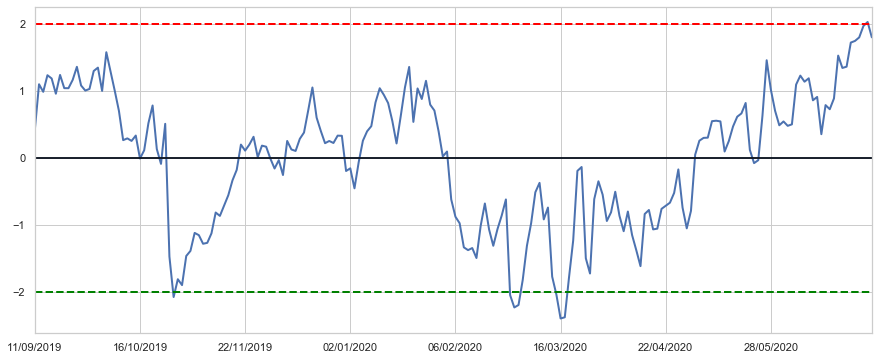

In [381]:
plot_residue(residue(y, x, period))

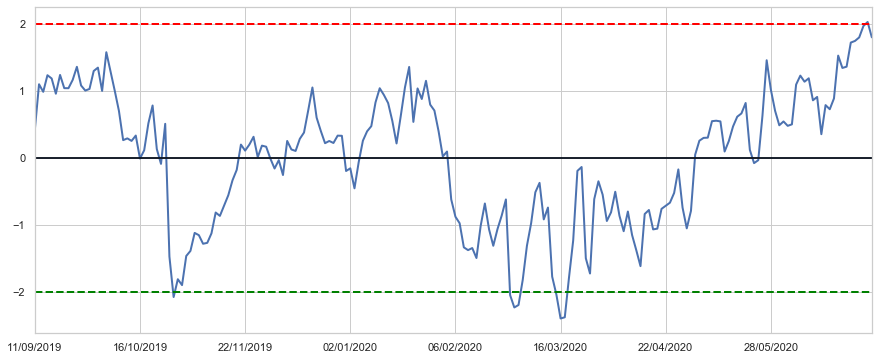

In [382]:
plot_residue(reg.resid)

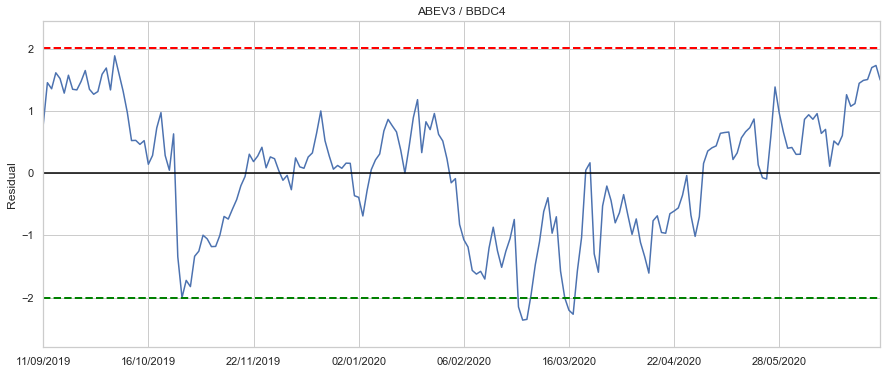

In [377]:
show(data[::-1], y_symbol, x_symbol, period)

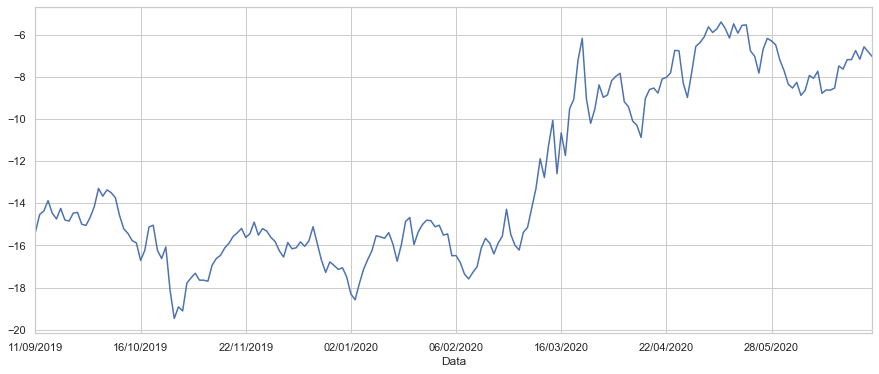

In [378]:
ratio_continuo(y, x, period)[::-1].plot(figsize=(15,6))